In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import sklearn as skt
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import re
import collections
from nltk.tokenize import RegexpTokenizer

# Loading the dataset

In [2]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

# Chemin vers le fichier dans Google Drive
file_path = '/content/drive/My Drive/ISOT Dataset/True.csv'

# Charger le fichier CSV
true_df = pd.read_csv(file_path)

# Vérification des premières lignes du dataframe
true_df.head()

Mounted at /content/drive


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
# Chemin vers le fichier dans Google Drive
file_path = '/content/drive/My Drive/ISOT Dataset/Fake.csv'

# Charger le fichier CSV
fake_df = pd.read_csv(file_path)
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Data Preprocessing

Preprocessing of true and fake datasets for data optimisation and removal of blank and duplicate entries.

## Verified News Dataset

In [4]:
# TRUE DATASET
# Checking for NaN values
true_df.isna().sum()

,0
title,0
text,0
subject,0
date,0


In [5]:
true_df['title']

,title
0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...
...,...
21412,'Fully committed' NATO backs new U.S. approach...
21413,LexisNexis withdrew two products from Chinese ...
21414,Minsk cultural hub becomes haven from authorities
21415,Vatican upbeat on possibility of Pope Francis ...


In [6]:
# Define function for most common words
# https://github.com/remydeshayes/NLP_Pytorch/blob/main/Notebook%20-%20Fake_News%20Detection%20Pytorch%20-%20Billiot_Deshayes.ipynb
from collections import Counter


def most_common(corpus, nb_words):
    articles = corpus.str.split()
    # Explanation of nested list comprehension:
    # Iterate through every article in articles
    # Iterate through every word in article (second for in loop)
    # Add word to the np.array if it is not a stopword (nltk)
    words = np.array([word for article in articles for word in article if word.lower() not in stopwords])
    counter = Counter(words)
    d = pd.DataFrame(counter, index=['occurences']).transpose().reset_index()
    d.columns = ['word', 'occurences']
    d = d.sort_values('occurences', ascending=False)
    return d[:nb_words]

In [7]:
# Download stopwords from nltk library
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
# This is VERY HIGH cpu compute (but it only takes a few seconds)
most_common(true_df['title'], 10)

,word,occurences
29,Trump,4400
0,U.S.,3872
45,says,2969
190,House,1360
522,North,905
38,White,788
69,Senate,720
22,Russia,718
523,Korea,695
135,Trump's,669


Even without computing the occurences, we notice the presence of the format "CITY (Reuters) - " at the beginning of each article. This is missing in all the articles from the fake_df.
We will delete this pattern format where it is present in the article within the first 50 characters of an article.
Failing to clean this would create a bias where perhaps, presence of the word Reuters would equate to non-falsified news.

In [9]:
import re

In [10]:
for i in range(0, len(true_df['title'])):
    try :
        # Search if CITY (Reuters) exist, if it does, shift the index
        # to 3 more spaces to accomodate the hyphen
        start = re.search('(Reuters)',true_df['title'][i][0:49]).end() + 3
    except:
        pass
    else:
        true_df['title'][i] = true_df['title'][i][start:]

In [11]:
true_df

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [12]:
# Check for duplicates or blank articles
# Conversion to dataframe to reduce output title clutter
duplicate = true_df['title'].value_counts()[true_df['title'].value_counts()>1]
duplicate = duplicate.rename_axis('unique_values').reset_index(name='counts')
duplicate

,unique_values,counts
0,Factbox: Trump fills top jobs for his administ...,14
1,Factbox: Contenders for senior jobs in Trump's...,8
2,Highlights: The Trump presidency on April 13 a...,8
3,Factbox: International reaction to arrest of R...,6
4,Highlights: The Trump presidency on April 21 a...,5
...,...,...
529,Trump fires back at Britain's May: 'Don't focu...,2
530,Trump to say in security speech that China is ...,2
531,Do not expect postcard-sized tax return from R...,2
532,Russian bombers strike Islamic State targets i...,2


In [13]:
# Number of duplicate entries
true_df['title'].value_counts()[true_df['title'].value_counts()>1].sum() - 212

917

In [14]:
# Deletion of duplicates
true_df = true_df.drop_duplicates(subset=['title'], ignore_index=True)

In [15]:
true_df.shape

(20822, 4)

For future EDA analysis, we keep the date column for plotting metrics. Date is processed into a uniform format.

In [16]:
true_df['date_len'] = [len(x) for x in true_df['date']]
print(true_df['date_len'].value_counts())
true_df = true_df.drop(['date_len'], axis=1)

date_len
17    6110
18    5608
19    2423
14    2003
16    1664
15    1610
13    1180
12     224
Name: count, dtype: int64


<ipython-input-16-2d5b7de3942a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_df['date_len'] = [len(x) for x in true_df['date']]


In [17]:
true_df

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
20817,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,worldnews,"August 21, 2017"
20818,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
20819,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
20820,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [18]:
from datetime import datetime

In [19]:
# All data format is uniform (month date, year)
# Unifying the date format to datetime
dates = []
for x in true_df['date']:
    date = datetime.strptime(x,'%B %d, %Y ')
    dates.append(date)
true_df['date'] = dates

In [20]:
true_df

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29
...,...,...,...,...
20817,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,worldnews,2017-08-21
20818,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22
20819,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22
20820,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22


In [21]:
true_df['date_len'] = [len(str(x)) for x in true_df['date']]
print(true_df['date_len'].value_counts())
true_df = true_df.drop(['date_len'], axis=1)

date_len
19    20822
Name: count, dtype: int64


Finally creating a label variable - 1 means the news is verified

In [22]:
true_df['label'] = 1

In [23]:
true_df

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1
...,...,...,...,...,...
20817,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,worldnews,2017-08-21,1
20818,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,1
20819,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,1
20820,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,1


## False News Dataset

We preprocess the articles in a similar manner as the true dataset

In [24]:
# FAKE DATASET
# Checking for NaN values
fake_df.isna().sum()

,0
title,0
text,0
subject,0
date,0


In [25]:
# Check for duplicates or blank articles
# Conversion to dataframe to reduce output title clutter
duplicate = fake_df['title'].value_counts()[fake_df['title'].value_counts()>1]
duplicate = duplicate.rename_axis('unique_values').reset_index(name='counts')
duplicate

,unique_values,counts
0,MEDIA IGNORES Time That Bill Clinton FIRED His...,6
1,ELEMENTARY SCHOOL PLANS ‘BLACKS ONLY’ FIELD TR...,4
2,FORMER FBI ASST DIRECTOR: “Jim Comey ‘Danced W...,4
3,AN INSIDE LOOK AT OBAMA’S 5-STAR SUMMER VACATI...,3
4,"GARY JOHNSON: Meet The “Creepy” Pro-Amnesty, A...",3
...,...,...
5091,HUSBAND OF PRESIDENTIAL Candidate Under CRIMIN...,2
5092,#BlackLivesMatter Terrorists Using #BlackRail ...,2
5093,WATCH: SMARTPHONE CAPTURES NEW BOATLOAD OF “Sc...,2
5094,WATCH MAGA RALLY LIVE: President Trump Holds M...,2


In [26]:
fake_df['title'].value_counts()[fake_df['title'].value_counts()>1].sum() - 4927 - 626

5121

In [27]:
# Values with no text - only title
blank = fake_df.loc[fake_df["title"] == duplicate["unique_values"][0]]
blank

,title,text,subject,date
10919,MEDIA IGNORES Time That Bill Clinton FIRED His...,"In its 109-year history, only one F.B.I. direc...",politics,"May 10, 2017"
10920,MEDIA IGNORES Time That Bill Clinton FIRED His...,At the recommendation of both Attorney General...,politics,"May 10, 2017"
10924,MEDIA IGNORES Time That Bill Clinton FIRED His...,"In its 109-year history, only one F.B.I. direc...",politics,"May 10, 2017"
18650,MEDIA IGNORES Time That Bill Clinton FIRED His...,"In its 109-year history, only one F.B.I. direc...",left-news,"May 10, 2017"
18651,MEDIA IGNORES Time That Bill Clinton FIRED His...,At the recommendation of both Attorney General...,left-news,"May 10, 2017"
18654,MEDIA IGNORES Time That Bill Clinton FIRED His...,"In its 109-year history, only one F.B.I. direc...",left-news,"May 10, 2017"


In [28]:
blank.index

Index([10919, 10920, 10924, 18650, 18651, 18654], dtype='int64')

In [29]:
# Dropping the blank news from the fake dataframe
fake_df = fake_df.drop(blank.index)

In [30]:
# Verification of removal (verified)
fake_df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [31]:
# Deletion of duplicates
fake_df = fake_df.drop_duplicates(subset=['title'], ignore_index=True)

In [32]:
fake_df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
17897,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,US_News,"January 7, 2016"
17898,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,US_News,"January 7, 2016"
17899,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,US_News,"January 6, 2016"
17900,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,US_News,"January 4, 2016"


We process the date column once again

In [33]:
fake_df['date_len'] = [len(x) for x in fake_df['date']]
print(fake_df['date_len'].value_counts())

date_len
12     6806
11     2586
16     2020
13     1722
17     1634
14     1622
15     1020
18      451
9        35
145       1
88        1
149       1
74        1
66        1
120       1
Name: count, dtype: int64


<ipython-input-33-e96d43b97295>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df['date_len'] = [len(x) for x in fake_df['date']]


In [34]:
fake_df.loc[fake_df["date_len"] > 18]

,title,text,subject,date,date_len
9357,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,145
15499,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,88
15500,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,149
15830,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,74
15831,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,66
16554,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,120


In [35]:
fake_df.loc[fake_df["date_len"] > 18].title

,title
9357,https://100percentfedup.com/served-roy-moore-v...
15499,https://100percentfedup.com/video-hillary-aske...
15500,https://100percentfedup.com/12-yr-old-black-co...
15830,https://fedup.wpengine.com/wp-content/uploads/...
15831,https://fedup.wpengine.com/wp-content/uploads/...
16554,Homepage


These are incorrect values for dates and they are not proper articles. So they will be dropped.

In [36]:
bad_date = fake_df.loc[fake_df["date_len"] > 18]

In [37]:
bad_date.index

Index([9357, 15499, 15500, 15830, 15831, 16554], dtype='int64')

In [38]:
# Dropping entries with bad date and no news from the fake dataframe
fake_df = fake_df.drop(index=bad_date.index)

In [39]:
# Verifying entries are dropped (verified)
fake_df

,title,text,subject,date,date_len
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",17
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",17
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",17
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",17
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",17
...,...,...,...,...,...
17897,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,US_News,"January 7, 2016",15
17898,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,US_News,"January 7, 2016",15
17899,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,US_News,"January 6, 2016",15
17900,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,US_News,"January 4, 2016",15


In [40]:
# All data format is uniform (month date, year)
# Unifying the date format to datetime
# Nested try except for ValueError exceptions in the fake dataset
dates = []
for x in fake_df['date']:
    try:
        date = datetime.strptime(x, '%B %d, %Y')
    except ValueError:
        try:
            date = datetime.strptime(x, '%d-%b-%y')
        except ValueError:
            date = datetime.strptime(x, '%b %d, %Y')
    dates.append(date)
fake_df['date'] = dates

In [41]:
# Verification
fake_df['date'].nunique

<bound method IndexOpsMixin.nunique of 0       2017-12-31
1       2017-12-31
2       2017-12-30
3       2017-12-29
4       2017-12-25
           ...    
17897   2016-01-07
17898   2016-01-07
17899   2016-01-06
17900   2016-01-04
17901   2016-01-02
Name: date, Length: 17896, dtype: datetime64[ns]>

All the dates are unique. Now the label for the fake dataset is finally added, where 0 means fake news

In [42]:
fake_df['label'] = 0

In [43]:
fake_df = fake_df.drop(['date_len'], axis=1)
fake_df

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0
...,...,...,...,...,...
17897,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,US_News,2016-01-07,0
17898,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,US_News,2016-01-07,0
17899,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,US_News,2016-01-06,0
17900,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,US_News,2016-01-04,0


Finally we concatenate both the dataframe

In [44]:
data = pd.concat([true_df, fake_df])
data = data.reset_index(drop=True)

In [45]:
data

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1
...,...,...,...,...,...
38713,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,US_News,2016-01-07,0
38714,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,US_News,2016-01-07,0
38715,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,US_News,2016-01-06,0
38716,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,US_News,2016-01-04,0


In [46]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

print("Number of words in dataset:", data['title'].apply(lambda x: len(x.split(' '))).sum())

Number of words in dataset: 472667


In [47]:
data.iloc[0,0:]

,0
title,"As U.S. budget fight looms, Republicans flip t..."
text,WASHINGTON (Reuters) - The head of a conservat...
subject,politicsNews
date,2017-12-31 00:00:00
label,1


In [48]:
number_of_samples=data.iloc[:,0].count()

In [49]:
y=data.iloc[:,8:].sum(axis=1).value_counts()/data.iloc[:,0].count()*100

# Exploratory Data Analysis

In [50]:
# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

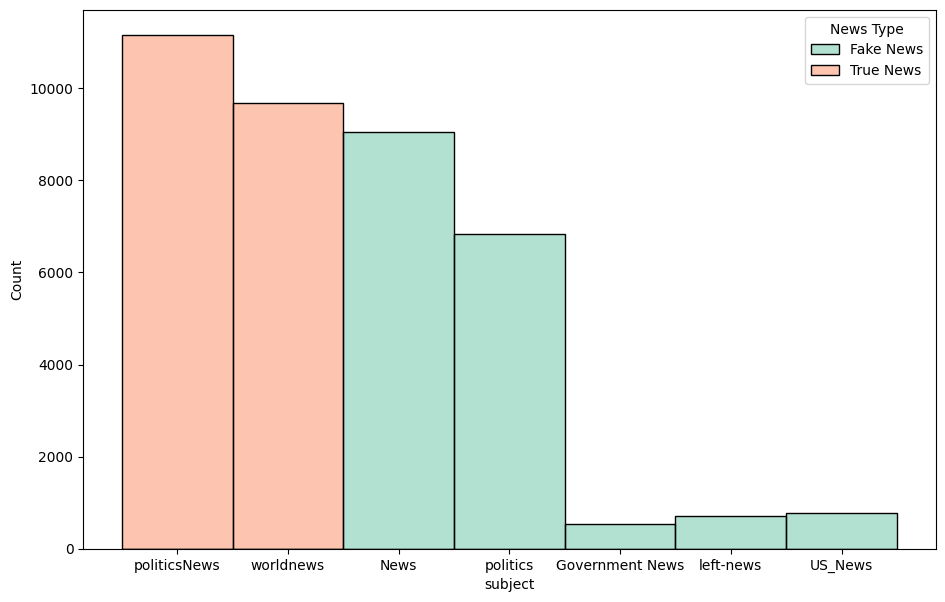

In [51]:
# Crée la figure et le graphique avec la palette de couleurs
fig, hist = plt.subplots(figsize=(11, 7))
colors = sns.color_palette("Set2", 2)

# Création du graphique avec la légende personnalisée
hist = sns.histplot(data=data, x='subject', hue='label', palette=colors)

# Personnalisation de la légende pour afficher "True News" et "Fake News"
hist.legend_.set_title('News Type')
new_labels = ['Fake News', 'True News']
for t, l in zip(hist.legend_.texts, new_labels):
    t.set_text(l)

# Afficher le graphique
plt.show()


The subjects in fake news are different from the subjects in verified news. Subject will not be taken into account.

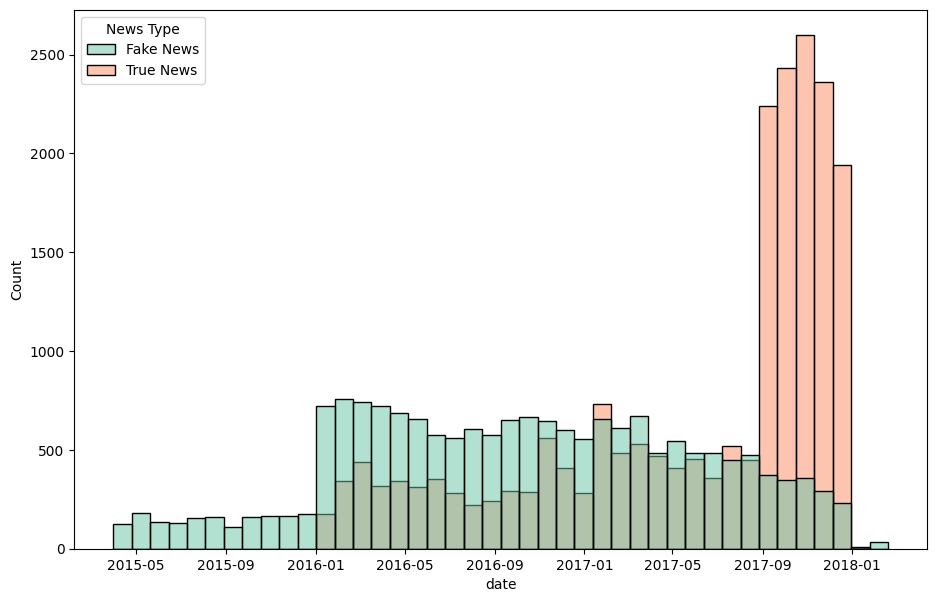

In [52]:
# Plotting histogram of article dates
fig, hist = plt.subplots(figsize=(11, 7))
colors = sns.color_palette("Set2", 2)

# Création du graphique avec la légende personnalisée
hist = sns.histplot(data=data, x = 'date', hue="label", palette=colors)

# Personnalisation de la légende pour afficher "True News" et "Fake News"
hist.legend_.set_title('News Type')
new_labels = ['Fake News', 'True News']
for t, l in zip(hist.legend_.texts, new_labels):
    t.set_text(l)

# Afficher le graphique
plt.show()


The date distribution of verified and false articles are varying. Fake articles span from before 2016 and verified articles are recorded from after 2016. Also, most of the verified articles in the dataset seem to be dated between Sep 2017 to Jan 2018.
Date will not be taken into account.

<ipython-input-53-0018f23268da>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(y='Average character length', x='Label', data=av, palette='Set2')


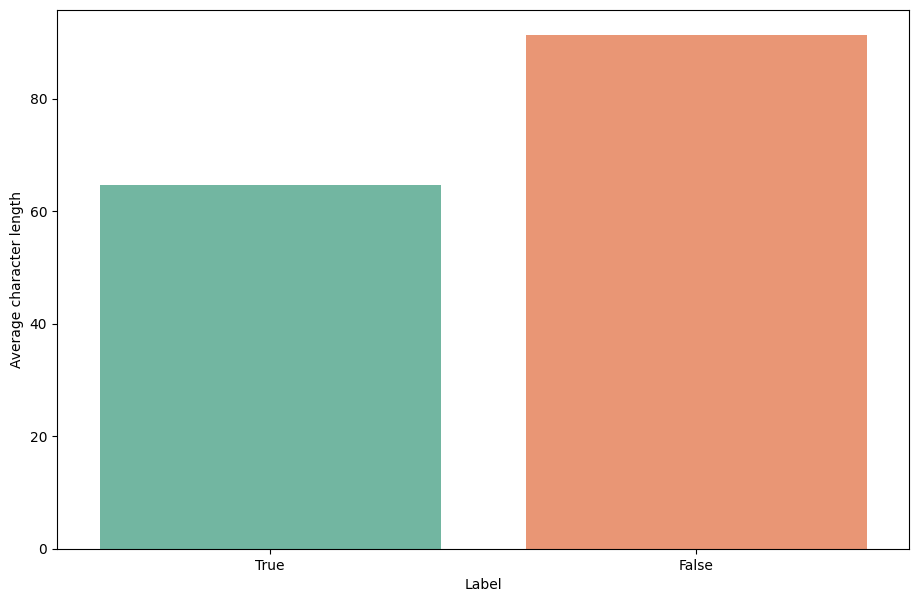

In [53]:
# title analysis
av_t = data[data['label'] == 1]['title'].apply(lambda x: len(x)).mean()
av_f = data[data['label'] == 0]['title'].apply(lambda x: len(x)).mean()
av = pd.DataFrame(data = {'Average character length': [av_t, av_f], 'Label':['True', 'False']})
fig, bar = plt.subplots(figsize = (11,7))
bar = sns.barplot(y='Average character length', x='Label', data=av, palette='Set2')

The average between all fake and true news is almost the same.

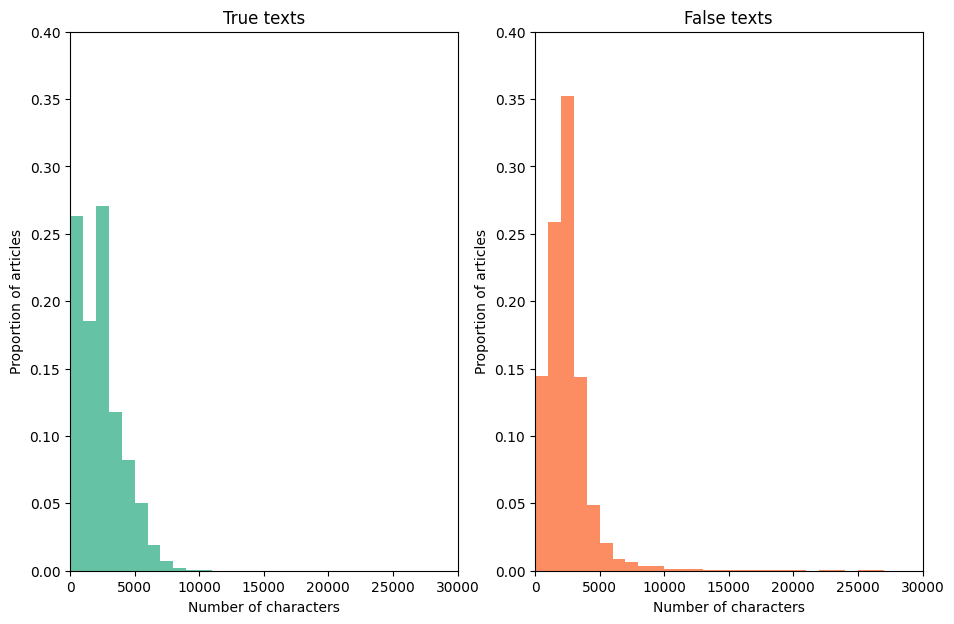

In [54]:
# Characters length of articles
len_cha_true = data[data['label'] == 1]['text'].apply(lambda x: len(x))
len_cha_fake = data[data['label'] == 0]['text'].apply(lambda x: len(x))

norm_weights_true = np.ones(len(len_cha_true))/len(len_cha_true)
norm_weights_fake = np.ones(len(len_cha_fake))/len(len_cha_fake)

bins = [i * 1000 for i in range(0,31)]

colors = sns.color_palette("Set2", 2)

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(len_cha_true, bins = bins, weights = norm_weights_true,color=colors[0])
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 30000)
hist1.set_xlabel('Number of characters')
hist1.set_ylabel('Proportion of articles')
hist1.set_title('True texts')

hist2.hist(len_cha_fake, bins = bins, weights = norm_weights_fake, color=colors[1])
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 30000)
hist2.set_xlabel('Number of characters')
hist2.set_ylabel('Proportion of articles')
hist2.set_title('False texts');

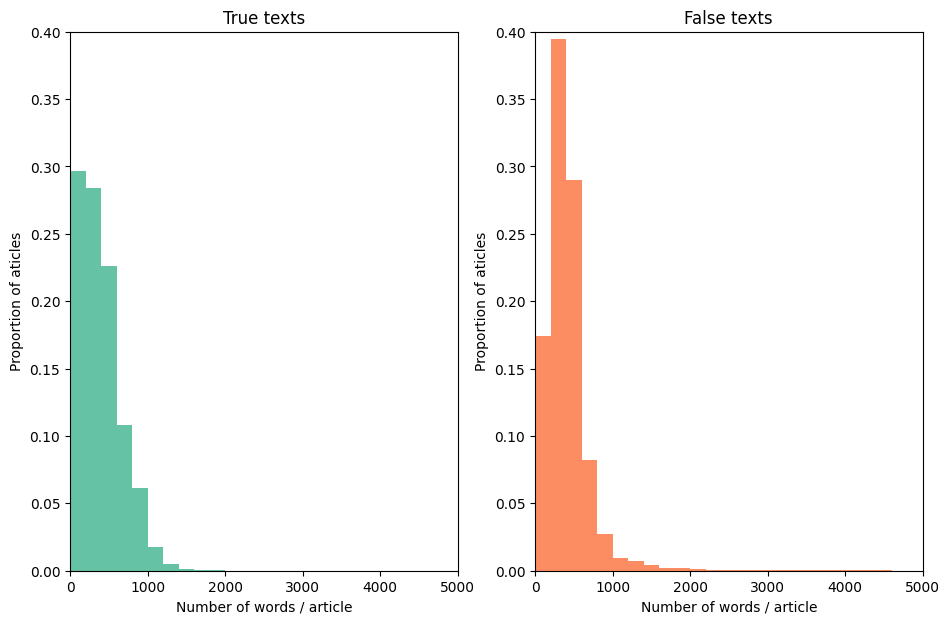

In [55]:
# Number of words per article
len_w_true = data[data['label'] == 1]['text'].str.split().map(lambda x: len(x))
len_w_fake = data[data['label'] == 0]['text'].str.split().map(lambda x: len(x))

norm_weights_true = np.ones(len(len_w_true))/len(len_w_true)
norm_weights_fake = np.ones(len(len_w_fake))/len(len_w_fake)

bins_ = [i * 200 for i in range(0,26)]

colors = sns.color_palette("Set2", 2)

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(len_w_true, bins = bins_, weights = norm_weights_true, color=colors[0])
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 5000)
hist1.set_xlabel('Number of words / article')
hist1.set_ylabel('Proportion of aticles')
hist1.set_title('True texts')
hist2.hist(len_w_fake, bins = bins_, weights = norm_weights_fake, color=colors[1])
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 5000)
hist2.set_xlabel('Number of words / article')
hist2.set_ylabel('Proportion of aticles')
hist2.set_title('False texts');

<ipython-input-56-1670adee649e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0], palette=colors);
<ipython-input-56-1670adee649e>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1], palette=colors);


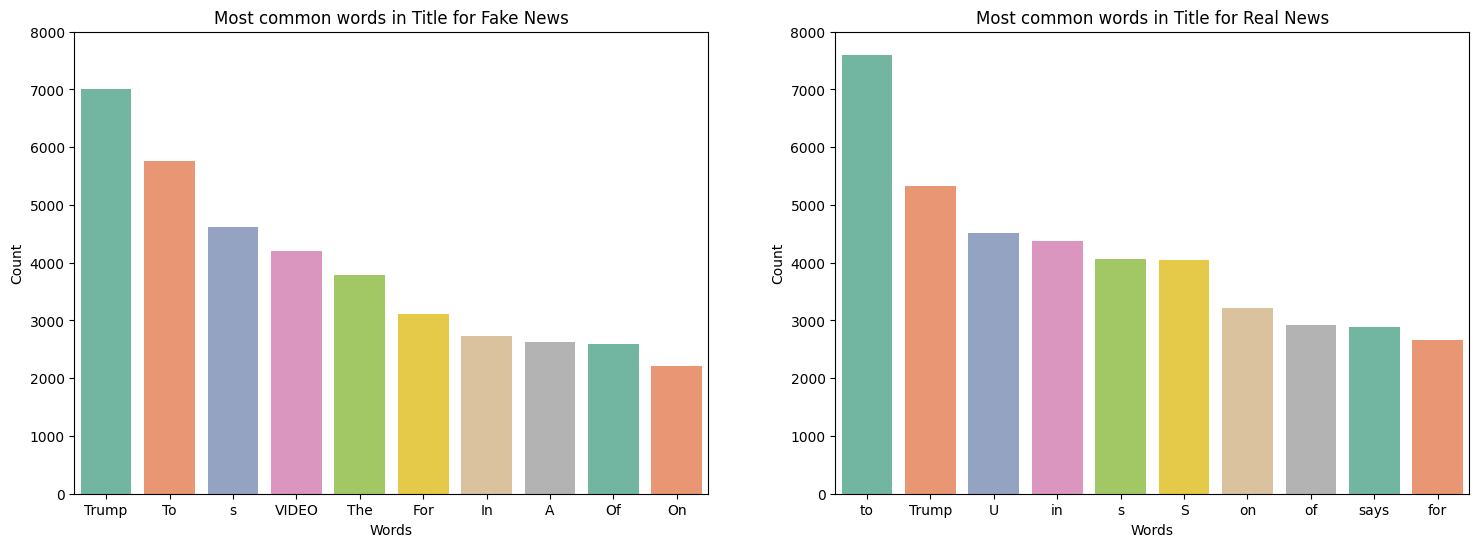

In [56]:

def get_wrd_count(text_lst):
    all_wrds = []
    tokenizer = RegexpTokenizer(r'\w+')
    for txt in text_lst:
        wrds = tokenizer.tokenize(txt)
        all_wrds.extend(wrds)
    wrd_counter = collections.Counter(all_wrds)
    return wrd_counter

fake_titles = data[data['label']== 0]['title'].tolist()
real_titles = data[data['label']== 1]['title'].tolist()

# word count

fake0_wrd = get_wrd_count(fake_titles)
real1_wrd = get_wrd_count(real_titles)

fake0_wrd_cnt_sorted = fake0_wrd.most_common(n=10)
real1_wrd_cnt_sorted = real1_wrd.most_common(n=10)
l0, h0, l1, h1 = [],[],[],[]
_ = [(l0.append(i[0]), h0.append(i[1])) for i in fake0_wrd_cnt_sorted]
_ = [(l1.append(i[0]), h1.append(i[1])) for i in real1_wrd_cnt_sorted]
#print(l1, h1)

colors = sns.color_palette("Set2", 10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6));
sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0], palette=colors);
ax[0].set_ylim(top=8000);
ax[0].set_xticks(ticks = list(range(len(l0))));
ax[0].set_xticklabels(l0);
ax[0].set_xlabel('Words');
ax[0].set_ylabel('Count');
ax[0].set_title("Most common words in Title for Fake News");

sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1], palette=colors);
ax[1].set_ylim(top=8000);
ax[1].set_xticks(ticks = list(range(len(l1))));
ax[1].set_xticklabels(l1);
ax[1].set_xlabel('Words');
ax[1].set_ylabel('Count');
ax[1].set_title("Most common words in Title for Real News");

# Text Pre-processing

In [57]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.8 MB/s eta 0:00:00


In [58]:
pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=c7290996a3c3cf522687ac1169dba0bf55782130f6a66f114ea2e0c90282f125
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [59]:
# Importing Libraries
import unidecode
import pandas as pd
import re
import time
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk import word_tokenize
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
def remove_hash(text1):
      return text1.replace("''", "")

In [61]:
def remove_tag(text2):
      return text2.replace("'", "")

In [62]:
def remove_tag(text3):
      return text3.replace("'", "")

In [63]:
def remove_underscore(text):
      return text.replace("_", " ")

In [64]:
data['title']=data['title'].apply(lambda text1: remove_hash(text1))

In [65]:
data['title']=data['title'].apply(lambda text2: remove_tag(text2))

In [66]:
data['title']=data['title'].apply(lambda text3: remove_tag(text3))

In [67]:
data['title']=data['title'].apply(lambda text: remove_underscore(text))

# Remove newlines & Tabs

In [68]:
def remove_newlines_tabs(text):
    """
    This function will remove all the occurrences of newlines, tabs, and combinations like: \\n, \\.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" after removal of newlines, tabs, \\n, \\ characters.

    Example:
    Input : This is her \\ first day at this place.\n Please,\t Be nice to her.\\n
    Output : This is her first day at this place. Please, Be nice to her.
    """

    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    Formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    return Formatted_text

In [69]:
data['title']=data['title'].apply(remove_newlines_tabs)

# Strip HTML Tags

In [70]:
def strip_html_tags(text):
    """
    This function will remove all the occurrences of html tags from the text.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" after removal of html tags.

    Example:
    Input : This is a nice place to live. <IMG>
    Output : This is a nice place to live.
    """
    # Initiating BeautifulSoup object soup.
    soup = BeautifulSoup(text, "html.parser")
    # Get all the text other than html tags.
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

In [71]:
data['title']=data['title'].apply(strip_html_tags)

<ipython-input-70-e98537e2dbe3>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


# Remove Links

In [72]:
def remove_links(text):
    """
    This function will remove all the occurrences of links.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" after removal of all types of links.

    Example:
    Input : To know more about this website: kajalyadav.com  visit: https://kajalyadav.com//Blogs
    Output : To know more about this website: visit:

    """

    # Removing all the occurrences of links that starts with https
    remove_https = re.sub(r'http\S+', '', text)
    # Remove all the occurrences of text that ends with .com
    remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
    return remove_com

In [73]:
data['title']=data['title'].apply(remove_links)

# Remove Accented Characters

In [74]:
# Code for accented characters removal
def accented_characters_removal(text):
    # this is a docstring
    """
    The function will remove accented characters from the
    text contained within the Dataset.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" with removed accented characters.

    Example:
    Input : Málaga, àéêöhello
    Output : Malaga, aeeohello

    """
    # Remove accented characters from text using unidecode.
    # Unidecode() - It takes unicode data & tries to represent it to ASCII characters.
    text = unidecode.unidecode(text)
    return text

In [75]:
data['title']=data['title'].apply(accented_characters_removal)

# Expand Contractions

In [76]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
}
# The code for expanding contraction words
def expand_contractions(text, contraction_mapping =  CONTRACTION_MAP):
    """expand shortened words to the actual form.
       e.g. don't to do not

       arguments:
            input_text: "text" of type "String".

       return:
            value: Text with expanded form of shorthened words.

       Example:
       Input : ain't, aren't, can't, cause, can't've
       Output :  is not, are not, cannot, because, cannot have

     """
    # Tokenizing text into tokens.
    list_Of_tokens = text.split(' ')

    # Checking for whether the given token matches with the Key & replacing word with key's value.

    # Check whether Word is in lidt_Of_tokens or not.
    for Word in list_Of_tokens:
        # Check whether found word is in dictionary "Contraction Map" or not as a key.
         if Word in CONTRACTION_MAP:
                # If Word is present in both dictionary & list_Of_tokens, replace that word with the key value.
                list_Of_tokens = [item.replace(Word, CONTRACTION_MAP[Word]) for item in list_Of_tokens]

    # Converting list of tokens to String.
    String_Of_tokens = ' '.join(str(e) for e in list_Of_tokens)
    return String_Of_tokens

In [77]:
data['title']=data['title'].apply(expand_contractions)

## Removing special characters except (!,?)

In [78]:
# The code for removing special characters except (!,?)
def removing_special_characters(text):
    """Removing all the special characters except the one that is passed within
       the regex to match, as they have imp meaning in the text provided.


    arguments:
         input_text: "text" of type "String".

    return:
        value: Text with removed special characters that don't require.

    Example:
    Input : Hello, K-a-j-a-l. Thi*s is $100.05 : the payment that you will recieve! (Is this okay?)
    Output :  Hello, Kajal. This is $100.05 : the payment that you will recieve! Is this okay?

   """
    # The formatted text after removing not necessary punctuations.
    Formatted_Text = re.sub(r"[^a-zA-Z0-9:$-,%.@_#""'']+", ' ', text)
    # In the above regex expression,I am providing necessary set of punctuations that are frequent in this particular dataset.
    return Formatted_Text

In [79]:
data['title']=data['title'].apply(removing_special_characters)

In [80]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [81]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Removing stopwords

In [82]:
# The code for removing stopwords
stoplist = stopwords.words('english')
stoplist = set(stoplist)

def remove_urls(text):
    text = re.sub(r"(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*","",text)
    return text

def removing_stopwords(text):
    """This function will remove stopwords which doesn't add much meaning to a sentence
       & they can be remove safely without comprimising meaning of the sentence.

    arguments:
         input_text: "text" of type "String".

    return:
        value: Text after omitted all stopwords.

    Example:
    Input : This is Kajal from delhi who came here to study.
    Output : ["'This", 'Kajal', 'delhi', 'came', 'study', '.', "'"]

   """
    all_stop_words = stopwords.words('english')
    tokenizer = RegexpTokenizer(r'\w+')
    #" ".join([i for i in wrds if i.lower() not in all_stop_words])
    wrds = tokenizer.tokenize(remove_urls(text))
    wrds_c = [i for i in wrds if i.lower() not in all_stop_words]
    del tokenizer
    del all_stop_words
    return " ".join(wrds_c)

In [83]:
data['title']=data['title'].apply(removing_stopwords)

data.to_csv('data1.csv', index=False)

# Most frequent words

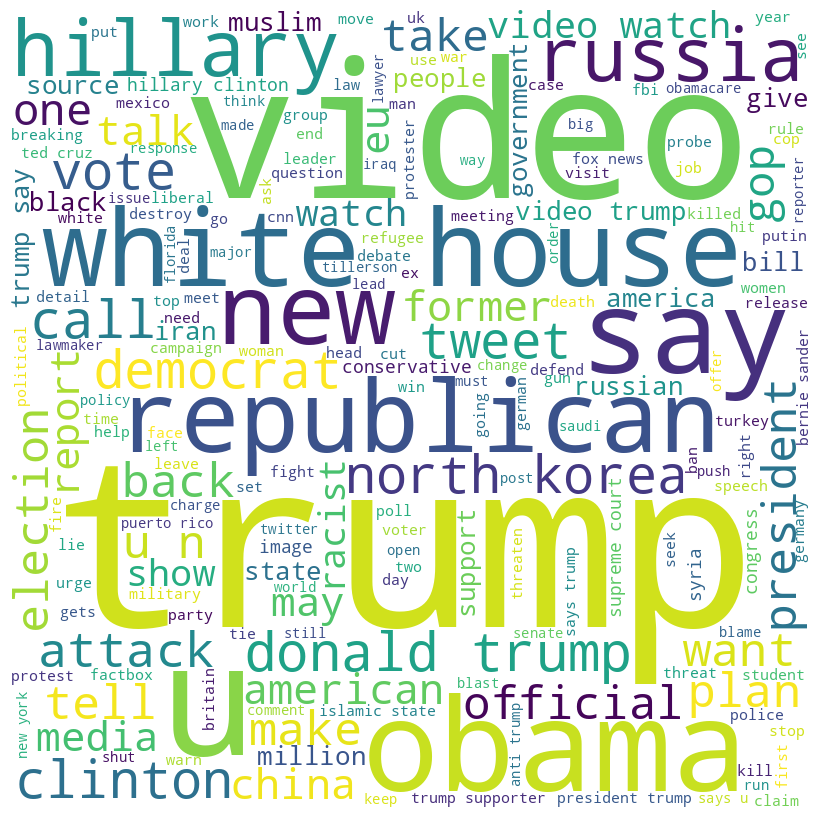

In [84]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Reads
df = data

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.title:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10,
                      font_path=None).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [85]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from sklearn.feature_extraction.text import CountVectorizer

# Fonction pour obtenir les bigrammes les plus fréquents
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Obtenir les 20 bigrammes les plus fréquents
common_words = get_top_n_bigram(data['title'], 20)
for word, freq in common_words:
    print(word, freq)

white house 1040
donald trump 759
north korea 662
trump says 384
hillary clinton 352
supreme court 339
president trump 322
fox news 303
islamic state 236
trump video 233
ted cruz 224
bernie sanders 208
anti trump 192
puerto rico 190
new york 187
says trump 183
trump supporter 169
travel ban 168
president obama 165
trump campaign 163


<ipython-input-86-8d50890de5ea>:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-86-8d50890de5ea>:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




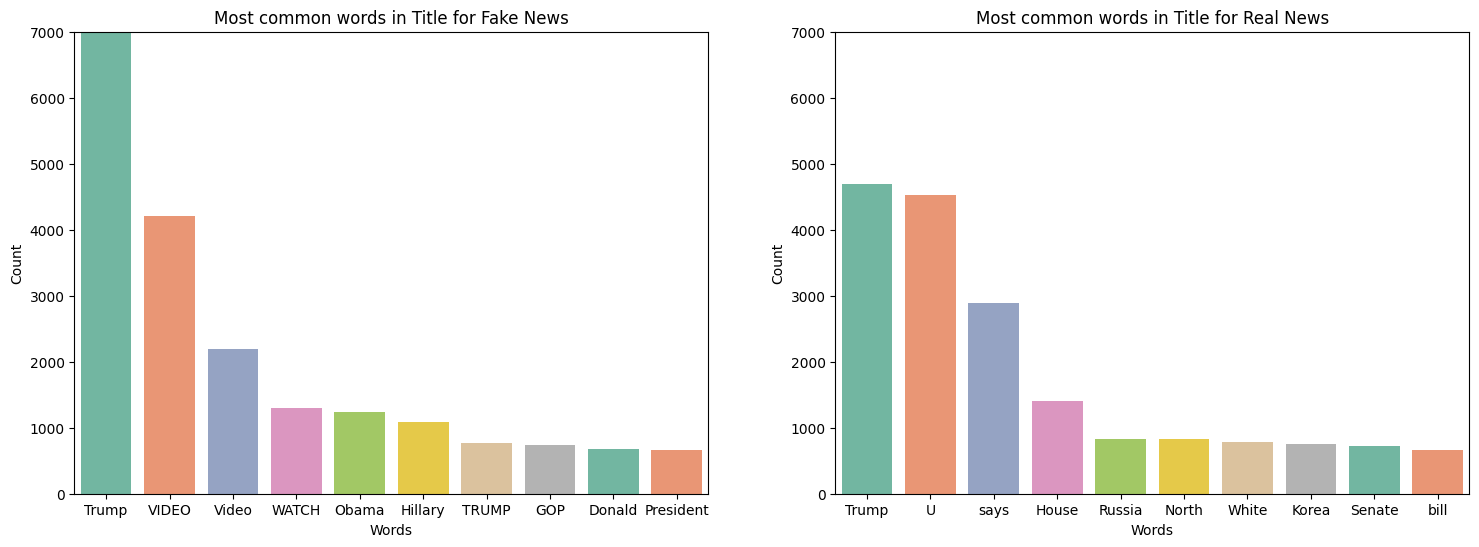

In [86]:
def get_wrd_count(text_lst):
    all_wrds = []
    tokenizer = RegexpTokenizer(r'\w+')
    for txt in text_lst:
        wrds = tokenizer.tokenize(txt)
        all_wrds.extend(wrds)
    wrd_counter = collections.Counter(all_wrds)
    return wrd_counter

fake_titles = data[data['label']== 0]['title'].tolist()
real_titles = data[data['label']== 1]['title'].tolist()

# word count

fake0_wrd = get_wrd_count(fake_titles)
real1_wrd = get_wrd_count(real_titles)

fake0_wrd_cnt_sorted = fake0_wrd.most_common(n=10)
real1_wrd_cnt_sorted = real1_wrd.most_common(n=10)
l0, h0, l1, h1 = [],[],[],[]
_ = [(l0.append(i[0]), h0.append(i[1])) for i in fake0_wrd_cnt_sorted]
_ = [(l1.append(i[0]), h1.append(i[1])) for i in real1_wrd_cnt_sorted]
#print(l1, h1)

colors = sns.color_palette("Set2", 10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6));
sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0], palette=colors);
ax[0].set_ylim(top=7000);
ax[0].set_xticks(ticks = list(range(len(l0))));
ax[0].set_xticklabels(l0);
ax[0].set_xlabel('Words');
ax[0].set_ylabel('Count');
ax[0].set_title("Most common words in Title for Fake News");

sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1], palette=colors);
ax[1].set_ylim(top=7000);
ax[1].set_xticks(ticks = list(range(len(l1))));
ax[1].set_xticklabels(l1);
ax[1].set_xlabel('Words');
ax[1].set_ylabel('Count');
ax[1].set_title("Most common words in Title for Real News");

In [87]:
import pandas as pd
import numpy as np
from textblob import TextBlob, Word, Blobber

In [88]:
data['polarity'] = data['title'].map(lambda text: TextBlob(text).sentiment.polarity)

In [89]:
print(data.shape)

(38718, 6)


In [90]:
data.head(4)

,title,text,subject,date,label,polarity
0,U budget fight looms Republicans flip fiscal s...,WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,0.0
1,U military accept transgender recruits Monday ...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,-0.1
2,Senior U Republican senator Let Mr Mueller job,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,0.0
3,FBI Russia probe helped Australian diplomat ti...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,0.0


### Define score range for positive and negative

In [91]:
def classify_sentiment(value):
    if value < 0:
        return 'negative'
    elif value > 0:
        return 'positive'
    else:
        return 'neutre'

data['sentiment'] = data['polarity'].apply(classify_sentiment)
data.tail()

,title,text,subject,date,label,polarity,sentiment
38713,White House Theatrics Gun Control,21st Century Wire says All the world s a stage...,US_News,2016-01-07,0,0.00,neutre
38714,Activists Terrorists Media Controls Dictates N...,Randy Johnson 21st Century WireThe majority ...,US_News,2016-01-07,0,0.00,neutre
38715,BOILER ROOM Surrender Retreat Heads Roll EP 38,Tune in to the Alternate Current Radio Network...,US_News,2016-01-06,0,0.00,neutre
38716,Federal Showdown Looms Oregon BLM Abuse Local ...,21st Century Wire says A new front has just op...,US_News,2016-01-04,0,0.00,neutre
38717,Troubled King Chicago Rahm Emanuel Desperate S...,21st Century Wire says It s not that far away....,US_News,2016-01-02,0,-0.55,negative


In [92]:
data['label'] = data['label'].map({0: 'Fausse', 1: 'Réelle'})


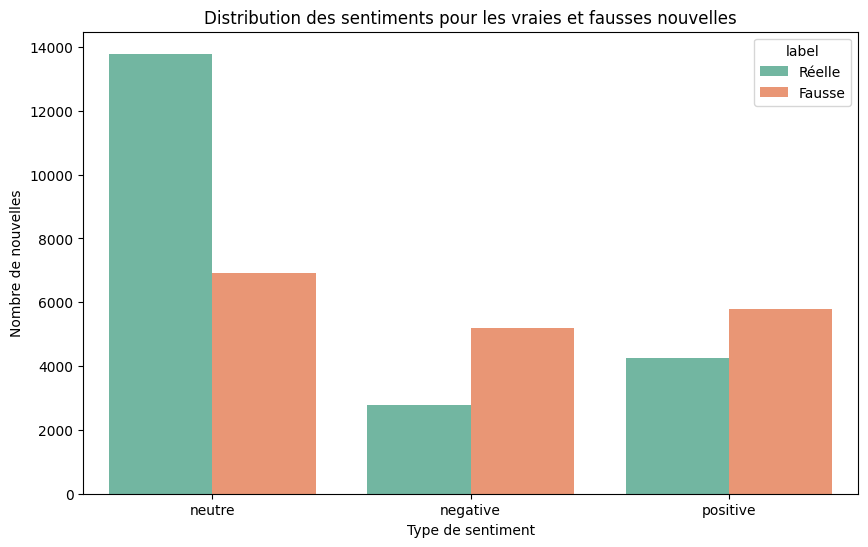

In [93]:
# Visualiser la répartition des sentiments pour les vraies et fausses nouvelles
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', hue='label', palette='Set2')

# Ajouter des titres et des labels
plt.title('Distribution des sentiments pour les vraies et fausses nouvelles')
plt.xlabel('Type de sentiment')
plt.ylabel('Nombre de nouvelles')

# Affichage de la visualisation
plt.show()

In [94]:
data = data[['text', 'subject', 'title','polarity','sentiment']]

In [95]:
data

,text,subject,title,polarity,sentiment
0,WASHINGTON (Reuters) - The head of a conservat...,politicsNews,U budget fight looms Republicans flip fiscal s...,0.00,neutre
1,WASHINGTON (Reuters) - Transgender people will...,politicsNews,U military accept transgender recruits Monday ...,-0.10,negative
2,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,Senior U Republican senator Let Mr Mueller job,0.00,neutre
3,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,FBI Russia probe helped Australian diplomat ti...,0.00,neutre
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,Trump wants Postal Service charge much Amazon ...,0.20,positive
...,...,...,...,...,...
38713,21st Century Wire says All the world s a stage...,US_News,White House Theatrics Gun Control,0.00,neutre
38714,Randy Johnson 21st Century WireThe majority ...,US_News,Activists Terrorists Media Controls Dictates N...,0.00,neutre
38715,Tune in to the Alternate Current Radio Network...,US_News,BOILER ROOM Surrender Retreat Heads Roll EP 38,0.00,neutre
38716,21st Century Wire says A new front has just op...,US_News,Federal Showdown Looms Oregon BLM Abuse Local ...,0.00,neutre


### Assgin positive 1, negative 0

In [96]:
stm_dic =  {'positive':1, 'neutre':1, 'negative':0}
data['sentiment'] = data['sentiment'].replace(stm_dic)

<ipython-input-96-13abcfd6a480>:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [97]:
data

,text,subject,title,polarity,sentiment
0,WASHINGTON (Reuters) - The head of a conservat...,politicsNews,U budget fight looms Republicans flip fiscal s...,0.00,1
1,WASHINGTON (Reuters) - Transgender people will...,politicsNews,U military accept transgender recruits Monday ...,-0.10,0
2,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,Senior U Republican senator Let Mr Mueller job,0.00,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,FBI Russia probe helped Australian diplomat ti...,0.00,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,Trump wants Postal Service charge much Amazon ...,0.20,1
...,...,...,...,...,...
38713,21st Century Wire says All the world s a stage...,US_News,White House Theatrics Gun Control,0.00,1
38714,Randy Johnson 21st Century WireThe majority ...,US_News,Activists Terrorists Media Controls Dictates N...,0.00,1
38715,Tune in to the Alternate Current Radio Network...,US_News,BOILER ROOM Surrender Retreat Heads Roll EP 38,0.00,1
38716,21st Century Wire says A new front has just op...,US_News,Federal Showdown Looms Oregon BLM Abuse Local ...,0.00,1


In [98]:
data['sentiment'].value_counts()

,count
sentiment,
1,30735
0,7983


In [99]:
data.fillna(value='', inplace=True)

# BERT Model

In [100]:
import random, time
from babel.dates import format_date, format_datetime, format_time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score

import torch
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import transformers, os
from transformers import BertModel, AutoModel, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification

In [101]:
# Check device
# Get the GPU device name if available.
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

torch.cuda.empty_cache()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

There are %d GPU(s) available. 1
We will use the GPU: Tesla T4


In [102]:
# Split test and train data using 25% of the dataset for validation purposes
x_train, x_test, y_train, y_test = train_test_split(data['title'],
                                                      data['sentiment'], test_size=0.25, shuffle=True, random_state=42)

In [103]:
# Obtain a 10% test set from train set
X_train_Transformer, X_val_Transformer, y_train_Transformer, y_val_Transformer = train_test_split(
                                                    x_train, y_train, test_size=0.20, random_state=42)

In [104]:
print(np.unique(y_train))  # Check unique labels


[0 1]


In [105]:
model_name = 'bert-base-uncased'
SEQ_LEN = 200
batch_size = 64
epochs = 10
learning_rate = 1e-5 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = 20
num_workers = 3

In [106]:
def get_split(text1):
    '''Get split of the text with 300 char lenght'''
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else:
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return str(l_total)

# Splits train and validation sets to be feed to the transformer which only accepts 512 tokens maximum
split_train_text = [get_split(t) for t in X_train_Transformer]
split_valid_text = [get_split(t) for t in X_val_Transformer]
split_test_text = [get_split(t) for t in x_test]

In [107]:
from transformers import BertTokenizer, TFBertModel

# Load the RoBERTa tokenizer and tokenize the data
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [108]:
trencoding = tokenizer.batch_encode_plus(
  list(split_train_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

valencoding = tokenizer.batch_encode_plus(
  list(split_valid_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)


testencoding = tokenizer.batch_encode_plus(
  list(split_test_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

In [109]:
tokenizer.special_tokens_map


{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [110]:
trencoding.keys()


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

### Find Class Weights¶


In [111]:
# Example usage
class_wts = compute_class_weight(
    class_weight='balanced',               # This argument specifies that weights should be computed based on class frequencies.
    classes=np.unique(data['sentiment'].values.tolist()), # Unique classes in your data
    y=data['sentiment']                   # The target labels
)

print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
#cross_entropy  = nn.NLLLoss(weight=weights)
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

[2.42502818 0.62986823]


In [112]:
def loadData(prep_df, batch_size, num_workers, sampler):

    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

## convert lists to tensors
train_seq = torch.tensor(trencoding['input_ids'])
train_mask = torch.tensor(trencoding['attention_mask'])
train_token_ids = torch.tensor(trencoding['token_type_ids'])
train_sentiment_scores = torch.tensor(y_train_Transformer.values, dtype=torch.float32).unsqueeze(1)
train_y = torch.tensor(y_train_Transformer.tolist())

val_seq = torch.tensor(valencoding['input_ids'])
val_mask = torch.tensor(valencoding['attention_mask'])
val_token_ids = torch.tensor(valencoding['token_type_ids'])
val_sentiment_scores = torch.tensor(y_val_Transformer.values, dtype=torch.float32).unsqueeze(1)
val_y = torch.tensor(y_val_Transformer.tolist())

test_seq = torch.tensor(testencoding['input_ids'])
test_mask = torch.tensor(testencoding['attention_mask'])
test_token_ids = torch.tensor(testencoding['token_type_ids'])
test_sentiment_scores = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
test_y = torch.tensor(y_test.tolist())

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_token_ids, train_sentiment_scores, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, num_workers, train_sampler)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_token_ids, val_sentiment_scores, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, batch_size, num_workers, val_sampler)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_sentiment_scores, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)


print('Number of data in the train set', len(traindata))
print('Number of data in the validation set', len(valdata))
print('Number of data in the test set', len(testdata))

Number of data in the train set 363
Number of data in the validation set 91
Number of data in the test set 152


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



In [113]:
batch_size

64

# Load BERT model¶


In [114]:
class BERT_Arch(nn.Module):
    def __init__(self, n_classes, freeze_bert=False):
        super(BERT_Arch, self).__init__()
        # Charger le modèle BERT pré-entraîné
        self.bert = BertModel.from_pretrained(model_name, return_dict=False)

        # Geler certaines couches de BERT (par exemple, les 6 premières)
        if freeze_bert:
            for name, param in self.bert.named_parameters():
                if 'encoder.layer.0' in name or 'encoder.layer.1' in name or 'encoder.layer.2' in name or 'encoder.layer.3' in name or 'encoder.layer.4' in name or 'encoder.layer.5' in name:
                    param.requires_grad = False

        # Dropout et fully connected layers
        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size + 1, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 16)  # Ajout d'une deuxième couche fully-connected
        self.bn = nn.BatchNorm1d(16)  # Normalisation
        self.bert_drop_2 = nn.Dropout(0.58)  # Dropout modifié

        # Couche de sortie
        self.out = nn.Linear(16, n_classes)  # Ajustement de la taille finale

    def forward(self, input_ids, attention_mask, token_type_ids, sentiment_scores):
        # Obtenir les embeddings de BERT
        last_hidden_state, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Utiliser l'embedding du token [CLS] pour la classification
        cls_embedding = last_hidden_state[:, 0, :]

        # Concaténer les embeddings BERT avec les scores de sentiment
        combined_input = torch.cat((cls_embedding, sentiment_scores), dim=1)

        # Passer les embeddings à travers les couches fully connected
        output = self.bert_drop_1(combined_input)
        output = self.fc(output)
        output = torch.relu(output)  # Ajout de la fonction d'activation ReLU
        output = self.fc2(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.out(output)

        # Ajout de la fonction d'activation sigmoïde
        output = torch.sigmoid(output)

        return output

In [115]:
class_names = np.unique(data['sentiment'])
model = BERT_Arch(len(class_names))
model.to(device) # Model to GPU.

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

print('Preparing the optimizer...')
#optimizer
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Preparing the optimizer...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



# Train the BERT model¶


In [116]:
from sklearn.metrics import accuracy_score

def trainBERT():
    print('Training...')
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    total_labels = []

    for step, batch in enumerate(traindata):
        if step % 20 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(traindata)))

        if torch.cuda.is_available():
            batch = [r.to(device) for r in batch]

        sent_id, mask, token_type_ids, sentiment_scores, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask, token_type_ids, sentiment_scores)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()

        # Calculate accuracy
        preds_labels = torch.argmax(preds, dim=1)
        accuracy = accuracy_score(labels.cpu().numpy(), preds_labels.cpu().numpy())
        total_accuracy += accuracy

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        total_labels.append(labels.cpu().numpy())

        torch.cuda.empty_cache()

    avg_loss = total_loss / len(traindata)
    avg_accuracy = total_accuracy / len(traindata)
    total_preds = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)

    return avg_loss, avg_accuracy, total_preds, total_labels

In [117]:
def evaluate():
    print("\nEvaluating...")
    t0 = time.time()
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    total_labels = []

    for step, batch in enumerate(valdata):
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valdata)))

        if torch.cuda.is_available():
            batch = [t.to(device) for t in batch]

        sent_id, mask, token_type_ids, sentiment_scores, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask, token_type_ids, sentiment_scores)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

            preds_labels = torch.argmax(preds, dim=1)
            accuracy = accuracy_score(labels.cpu().numpy(), preds_labels.cpu().numpy())
            total_accuracy += accuracy

            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            total_labels.append(labels.cpu().numpy())

        torch.cuda.empty_cache()

    avg_loss = total_loss / len(valdata)
    avg_accuracy = total_accuracy / len(valdata)
    total_preds = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)

    return avg_loss, avg_accuracy, total_preds, total_labels


In [118]:
import matplotlib.pyplot as plt
import time

# Initialize tracking variables
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Track the total training time
total_training_time = 0

# Loop over the epochs
for epoch in range(epochs):
    print(f'\n Epoch {epoch + 1} / {epochs}')

    # Start time for the epoch
    epoch_start_time = time.time()

    # Training phase
    train_loss, train_accuracy, _, _ = trainBERT()

    # Validation phase
    valid_loss, valid_accuracy, _, _ = evaluate()

    # Calculate the time taken for the epoch
    epoch_time = time.time() - epoch_start_time
    total_training_time += epoch_time

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Training Accuracy: {train_accuracy:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'Validation Accuracy: {valid_accuracy:.3f}')
    print(f'Time taken for Epoch {epoch + 1}: {epoch_time:.2f} seconds')

    # Save the model if validation loss decreases
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('Saving model...')
        torch.save(model.state_dict(), 'bert_weights.pt')

    # Append losses and accuracies for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)


# Display the total training time
# Affichage du temps total d'entraînement en minutes
total_training_time_minutes = total_training_time / 60
print(f'Total training time: {total_training_time_minutes:.2f} minutes')



 Epoch 1 / 10
Training...
  Batch    20  of    363.
  Batch    40  of    363.
  Batch    60  of    363.
  Batch    80  of    363.
  Batch   100  of    363.
  Batch   120  of    363.
  Batch   140  of    363.
  Batch   160  of    363.
  Batch   180  of    363.
  Batch   200  of    363.
  Batch   220  of    363.
  Batch   240  of    363.
  Batch   260  of    363.
  Batch   280  of    363.
  Batch   300  of    363.
  Batch   320  of    363.
  Batch   340  of    363.
  Batch   360  of    363.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     91.
  Batch    40  of     91.
  Batch    60  of     91.
  Batch    80  of     91.

Training Loss: 0.609
Training Accuracy: 0.695
Validation Loss: 0.504
Validation Accuracy: 0.844
Time taken for Epoch 1: 193.58 seconds
Saving model...

 Epoch 2 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    363.
  Batch    40  of    363.
  Batch    60  of    363.
  Batch    80  of    363.
  Batch   100  of    363.
  Batch   120  of    363.
  Batch   140  of    363.
  Batch   160  of    363.
  Batch   180  of    363.
  Batch   200  of    363.
  Batch   220  of    363.
  Batch   240  of    363.
  Batch   260  of    363.
  Batch   280  of    363.
  Batch   300  of    363.
  Batch   320  of    363.
  Batch   340  of    363.
  Batch   360  of    363.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     91.
  Batch    40  of     91.
  Batch    60  of     91.
  Batch    80  of     91.

Training Loss: 0.506
Training Accuracy: 0.900
Validation Loss: 0.465
Validation Accuracy: 0.926
Time taken for Epoch 2: 203.45 seconds
Saving model...

 Epoch 3 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    363.
  Batch    40  of    363.
  Batch    60  of    363.
  Batch    80  of    363.
  Batch   100  of    363.
  Batch   120  of    363.
  Batch   140  of    363.
  Batch   160  of    363.
  Batch   180  of    363.
  Batch   200  of    363.
  Batch   220  of    363.
  Batch   240  of    363.
  Batch   260  of    363.
  Batch   280  of    363.
  Batch   300  of    363.
  Batch   320  of    363.
  Batch   340  of    363.
  Batch   360  of    363.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     91.
  Batch    40  of     91.
  Batch    60  of     91.
  Batch    80  of     91.

Training Loss: 0.483
Training Accuracy: 0.938
Validation Loss: 0.458
Validation Accuracy: 0.927
Time taken for Epoch 3: 207.51 seconds
Saving model...

 Epoch 4 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    363.
  Batch    40  of    363.
  Batch    60  of    363.
  Batch    80  of    363.
  Batch   100  of    363.
  Batch   120  of    363.
  Batch   140  of    363.
  Batch   160  of    363.
  Batch   180  of    363.
  Batch   200  of    363.
  Batch   220  of    363.
  Batch   240  of    363.
  Batch   260  of    363.
  Batch   280  of    363.
  Batch   300  of    363.
  Batch   320  of    363.
  Batch   340  of    363.
  Batch   360  of    363.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     91.
  Batch    40  of     91.
  Batch    60  of     91.
  Batch    80  of     91.

Training Loss: 0.471
Training Accuracy: 0.950
Validation Loss: 0.446
Validation Accuracy: 0.947
Time taken for Epoch 4: 207.76 seconds
Saving model...

 Epoch 5 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    363.
  Batch    40  of    363.
  Batch    60  of    363.
  Batch    80  of    363.
  Batch   100  of    363.
  Batch   120  of    363.
  Batch   140  of    363.
  Batch   160  of    363.
  Batch   180  of    363.
  Batch   200  of    363.
  Batch   220  of    363.
  Batch   240  of    363.
  Batch   260  of    363.
  Batch   280  of    363.
  Batch   300  of    363.
  Batch   320  of    363.
  Batch   340  of    363.
  Batch   360  of    363.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     91.
  Batch    40  of     91.
  Batch    60  of     91.
  Batch    80  of     91.

Training Loss: 0.457
Training Accuracy: 0.963
Validation Loss: 0.435
Validation Accuracy: 0.960
Time taken for Epoch 5: 208.53 seconds
Saving model...

 Epoch 6 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    363.
  Batch    40  of    363.
  Batch    60  of    363.
  Batch    80  of    363.
  Batch   100  of    363.
  Batch   120  of    363.
  Batch   140  of    363.
  Batch   160  of    363.
  Batch   180  of    363.
  Batch   200  of    363.
  Batch   220  of    363.
  Batch   240  of    363.
  Batch   260  of    363.
  Batch   280  of    363.
  Batch   300  of    363.
  Batch   320  of    363.
  Batch   340  of    363.
  Batch   360  of    363.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     91.
  Batch    40  of     91.
  Batch    60  of     91.
  Batch    80  of     91.

Training Loss: 0.448
Training Accuracy: 0.971
Validation Loss: 0.429
Validation Accuracy: 0.967
Time taken for Epoch 6: 208.32 seconds
Saving model...

 Epoch 7 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    363.
  Batch    40  of    363.
  Batch    60  of    363.
  Batch    80  of    363.
  Batch   100  of    363.
  Batch   120  of    363.
  Batch   140  of    363.
  Batch   160  of    363.
  Batch   180  of    363.
  Batch   200  of    363.
  Batch   220  of    363.
  Batch   240  of    363.
  Batch   260  of    363.
  Batch   280  of    363.
  Batch   300  of    363.
  Batch   320  of    363.
  Batch   340  of    363.
  Batch   360  of    363.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     91.
  Batch    40  of     91.
  Batch    60  of     91.
  Batch    80  of     91.

Training Loss: 0.440
Training Accuracy: 0.977
Validation Loss: 0.425
Validation Accuracy: 0.968
Time taken for Epoch 7: 208.38 seconds
Saving model...

 Epoch 8 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    363.
  Batch    40  of    363.
  Batch    60  of    363.
  Batch    80  of    363.
  Batch   100  of    363.
  Batch   120  of    363.
  Batch   140  of    363.
  Batch   160  of    363.
  Batch   180  of    363.
  Batch   200  of    363.
  Batch   220  of    363.
  Batch   240  of    363.
  Batch   260  of    363.
  Batch   280  of    363.
  Batch   300  of    363.
  Batch   320  of    363.
  Batch   340  of    363.
  Batch   360  of    363.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     91.
  Batch    40  of     91.
  Batch    60  of     91.
  Batch    80  of     91.

Training Loss: 0.434
Training Accuracy: 0.980
Validation Loss: 0.427
Validation Accuracy: 0.952
Time taken for Epoch 8: 208.18 seconds

 Epoch 9 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    363.
  Batch    40  of    363.
  Batch    60  of    363.
  Batch    80  of    363.
  Batch   100  of    363.
  Batch   120  of    363.
  Batch   140  of    363.
  Batch   160  of    363.
  Batch   180  of    363.
  Batch   200  of    363.
  Batch   220  of    363.
  Batch   240  of    363.
  Batch   260  of    363.
  Batch   280  of    363.
  Batch   300  of    363.
  Batch   320  of    363.
  Batch   340  of    363.
  Batch   360  of    363.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     91.
  Batch    40  of     91.
  Batch    60  of     91.
  Batch    80  of     91.

Training Loss: 0.427
Training Accuracy: 0.982
Validation Loss: 0.419
Validation Accuracy: 0.962
Time taken for Epoch 9: 208.23 seconds
Saving model...

 Epoch 10 / 10
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of    363.
  Batch    40  of    363.
  Batch    60  of    363.
  Batch    80  of    363.
  Batch   100  of    363.
  Batch   120  of    363.
  Batch   140  of    363.
  Batch   160  of    363.
  Batch   180  of    363.
  Batch   200  of    363.
  Batch   220  of    363.
  Batch   240  of    363.
  Batch   260  of    363.
  Batch   280  of    363.
  Batch   300  of    363.
  Batch   320  of    363.
  Batch   340  of    363.
  Batch   360  of    363.

Evaluating...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  Batch    20  of     91.
  Batch    40  of     91.
  Batch    60  of     91.
  Batch    80  of     91.

Training Loss: 0.423
Training Accuracy: 0.985
Validation Loss: 0.415
Validation Accuracy: 0.971
Time taken for Epoch 10: 208.21 seconds
Saving model...
Total training time: 34.37 minutes


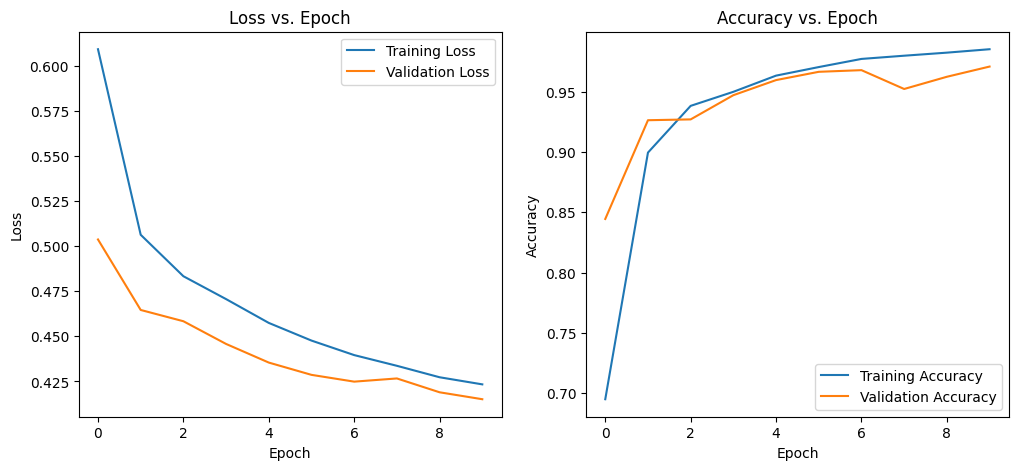

In [119]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epoch')

plt.show()

In [120]:
print('\nTest Set...')

test_preds = []

print('Total batches:', len(testdata))

for fold_index in range(0, 4):

    print('\nFold Model', fold_index)

    # Load the fold model
    path_model = 'bert_weights.pt'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the GPU
    model.to(device)

    stacked_val_labels = []

    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, test_batch in enumerate(testdata):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = test_batch[0].to(device)
        b_input_mask = test_batch[1].to(device)
        b_token_type_ids = test_batch[2].to(device)
        b_sentiment_scores = test_batch[3].to(device)
        b_test_y = test_batch[4].to(device)



        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        token_type_ids=b_token_type_ids,
                        sentiment_scores=b_sentiment_scores)

        # Get the preds
        preds = outputs[0]

        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()

        #true_labels.append(b_test_y.to('cpu').numpy().flatten())

        # Stack the predictions.
        if j == 0:  # first batch
            stacked_val_preds = val_preds

        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))

    test_preds.append(stacked_val_preds)


print('\nPrediction complete.')


Test Set...
Total batches: 152

Fold Model 0


<ipython-input-120-aa70bb2244b8>:13: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:




Fold Model 1

Fold Model 2

Fold Model 3

Prediction complete.


In [121]:
print(len(test_preds))
print(test_preds[:5])

4
[array([[0.9922306 , 0.047829  ],
       [0.22011755, 0.7497707 ],
       [0.20405313, 0.7574881 ],
       [0.20105535, 0.7592906 ],
       [0.21003145, 0.7544752 ],
       [0.20422602, 0.75776654],
       [0.99240816, 0.04618776],
       [0.20708077, 0.7577313 ],
       [0.20940682, 0.75367486],
       [0.99222696, 0.04702604],
       [0.19947135, 0.76329756],
       [0.20203972, 0.75854087],
       [0.19930987, 0.7624834 ],
       [0.19745429, 0.76283246],
       [0.9922741 , 0.04725915],
       [0.19858573, 0.76175493],
       [0.19423568, 0.7620522 ],
       [0.20296471, 0.7597964 ],
       [0.20525168, 0.75885606],
       [0.20113537, 0.76160747],
       [0.20190631, 0.7589947 ],
       [0.19426799, 0.7657192 ],
       [0.99137723, 0.05218822],
       [0.1988508 , 0.76345867],
       [0.20248288, 0.7585952 ],
       [0.99232435, 0.04658712],
       [0.19814982, 0.76352894],
       [0.19651732, 0.7651597 ],
       [0.19671823, 0.76619565],
       [0.99195534, 0.04876789],
       

In [122]:
# Sum the predictions of all fold models
for i, item in enumerate(test_preds):
    if i == 0:
        preds = item
    else:
        # Sum the matrices
        preds = item + preds

# Average the predictions
avg_preds = preds/(len(test_preds))

#print(preds)
#print()
#print(avg_preds)

# Take the argmax.
# This returns the column index of the max value in each row.
test_predictions = np.argmax(avg_preds, axis=1)

# Take a look of the output
print(type(test_predictions))
print(len(test_predictions))
print()
print(test_predictions)

<class 'numpy.ndarray'>
152

[0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0
 0 0 1 1]


In [123]:
true_y = []
for j, test_batch in enumerate(testdata):
    true_y.append(int(test_batch[3][0].numpy().flatten()))
print(true_y)

<ipython-input-123-339decd1dab9>:3: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1]


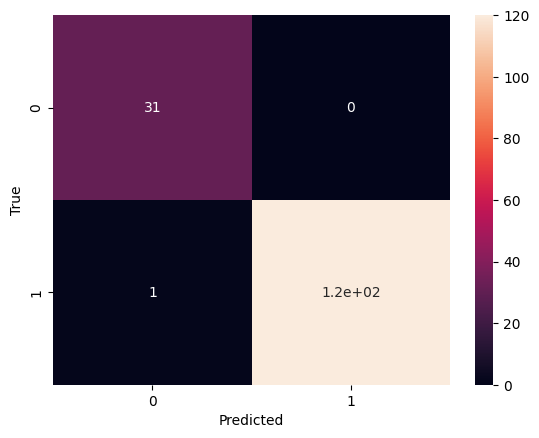

In [124]:
# Accuracy and classification report
target_names = ['true_y', 'predicted_y']

data = {'true_y': true_y,
       'predicted_y': test_predictions}

df_pred_BERT = pd.DataFrame(data, columns=['true_y','predicted_y'])

confusion_matrix = pd.crosstab(df_pred_BERT['true_y'], df_pred_BERT['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [125]:
print(classification_report(true_y, test_predictions))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       1.00      0.99      1.00       121

    accuracy                           0.99       152
   macro avg       0.98      1.00      0.99       152
weighted avg       0.99      0.99      0.99       152



In [126]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Accuracy of BERT model, {accuracy_score(true_y, test_predictions) * 100:.4f}%")
print(f"Precision of BERT model, {precision_score(true_y, test_predictions) * 100:.4f}%")
print(f"Recall of BERT model, {recall_score(true_y, test_predictions) * 100:.4f}%")
print(f"F1_score of BERT model, {f1_score(true_y, test_predictions) * 100:.4f}%")


Accuracy of BERT model, 99.3421%
Precision of BERT model, 100.0000%
Recall of BERT model, 99.1736%
F1_score of BERT model, 99.5851%
